# <span style="color:navy"> Esercitazione 4 </span>

### <span style="color:teal"> Esercizio 4.1 </span>

In questo esercizio ho implementato nel codice (NSL_SIMULATOR) il calcolo della distribuzione di velocità di Maxwell–Boltzmann per un sistema tridimensionale, utilizzando unità ridotte di Lennard-Jones.

$$p(v^*,T^*) = \frac{1}{(2\pi T^*)^{3/2}} 4\pi (v^*)^2 e^{-\frac{(v^*)^2}{2 T^*}}$$


La distribuzione di Maxwell–Boltzmann descrive la probabilità di trovare particelle con una certa velocità in un gas ideale, ed è un'ottima approssimazione anche per gas rarefatti a temperature ordinarie.

Come richiesto dall'esercizio ho implementato la $p(v^*,T^*)$ nel codice applicando la tecnica del data blocking per ottenere medie per blocco, medie progressive e incertezze progressive della distribuzione.

### <span style="color:teal"> Esercizio 4.2 </span>

In questo esercizio ho utilizzato il codice di Dinamica Molecolare esteso per simulare un sistema di particelle interagenti tramite il potenziale di Lennard-Jones (parametri tipo Argon: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m = 39.948$ amu), nelle condizioni tipiche di fase gassosa:
- Densità ridotta: $\rho^\star = 0.05$
- Temperatura ridotta: $T^\star \approx 2.0$
- Raggio di cut-off: $r_c = 5.0$


Per studiare l'evoluzione del sistema verso l'equilibrio, ho imposto una configurazione iniziale a bassa entropia, sia nella distribuzione spaziale che in quella delle velocità:
- Le posizioni iniziali sono state generate disponendo le particelle secondo una struttura fcc occupante solo metà del volume della scatola.
- Le velocità iniziali seguono una distribuzione $\delta(v_{T^*})$ centrata in $v_{T^*}$: ogni particella ha una solo componente di velocità non nulla, scelta tra $v_x$, $v_y$ o $v_z$, pari a $\pm v_{T^*}$, dove $v_{T^*}$ è coerente con l’energia cinetica iniziale attesa dalla temperatura.


L’obiettivo è osservare come il sistema, evolvendo tramite l’integrazione delle equazioni del moto, perda memoria della configurazione iniziale e converga verso la distribuzione di velocità di Maxwell–Boltzmann.

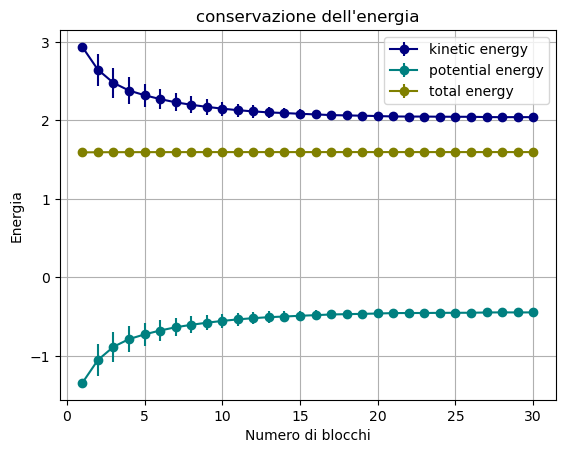

In [4]:
import matplotlib.pyplot as plt
import numpy as np

block_pofv, ave_pofv, err_pofv = np.loadtxt("OUTPUT_4.2/kinetic_energy.dat", usecols=(0,2,3), unpack=True)
block_pot, ave_pot, err_pot = np.loadtxt("OUTPUT_4.2/potential_energy.dat", usecols=(0,2,3),unpack=True)
block_tot, ave_tot, err_tot = np.loadtxt("OUTPUT_4.2/total_energy.dat", usecols=(0,2,3),unpack=True)

plt.errorbar(block_pofv, ave_pofv, err_pofv, label="kinetic energy", fmt="o-", color='navy', ecolor='navy')
plt.errorbar(block_pot, ave_pot, err_pot, label="potential energy", fmt="o-", color='teal', ecolor='teal')
plt.errorbar(block_tot, ave_tot, err_tot, label="total energy", fmt="o-", color='olive', ecolor='olive')
plt.xlabel("Numero di blocchi")
plt.ylabel("Energia")
plt.title("conservazione dell'energia")
plt.grid(True)
plt.legend()


                                        



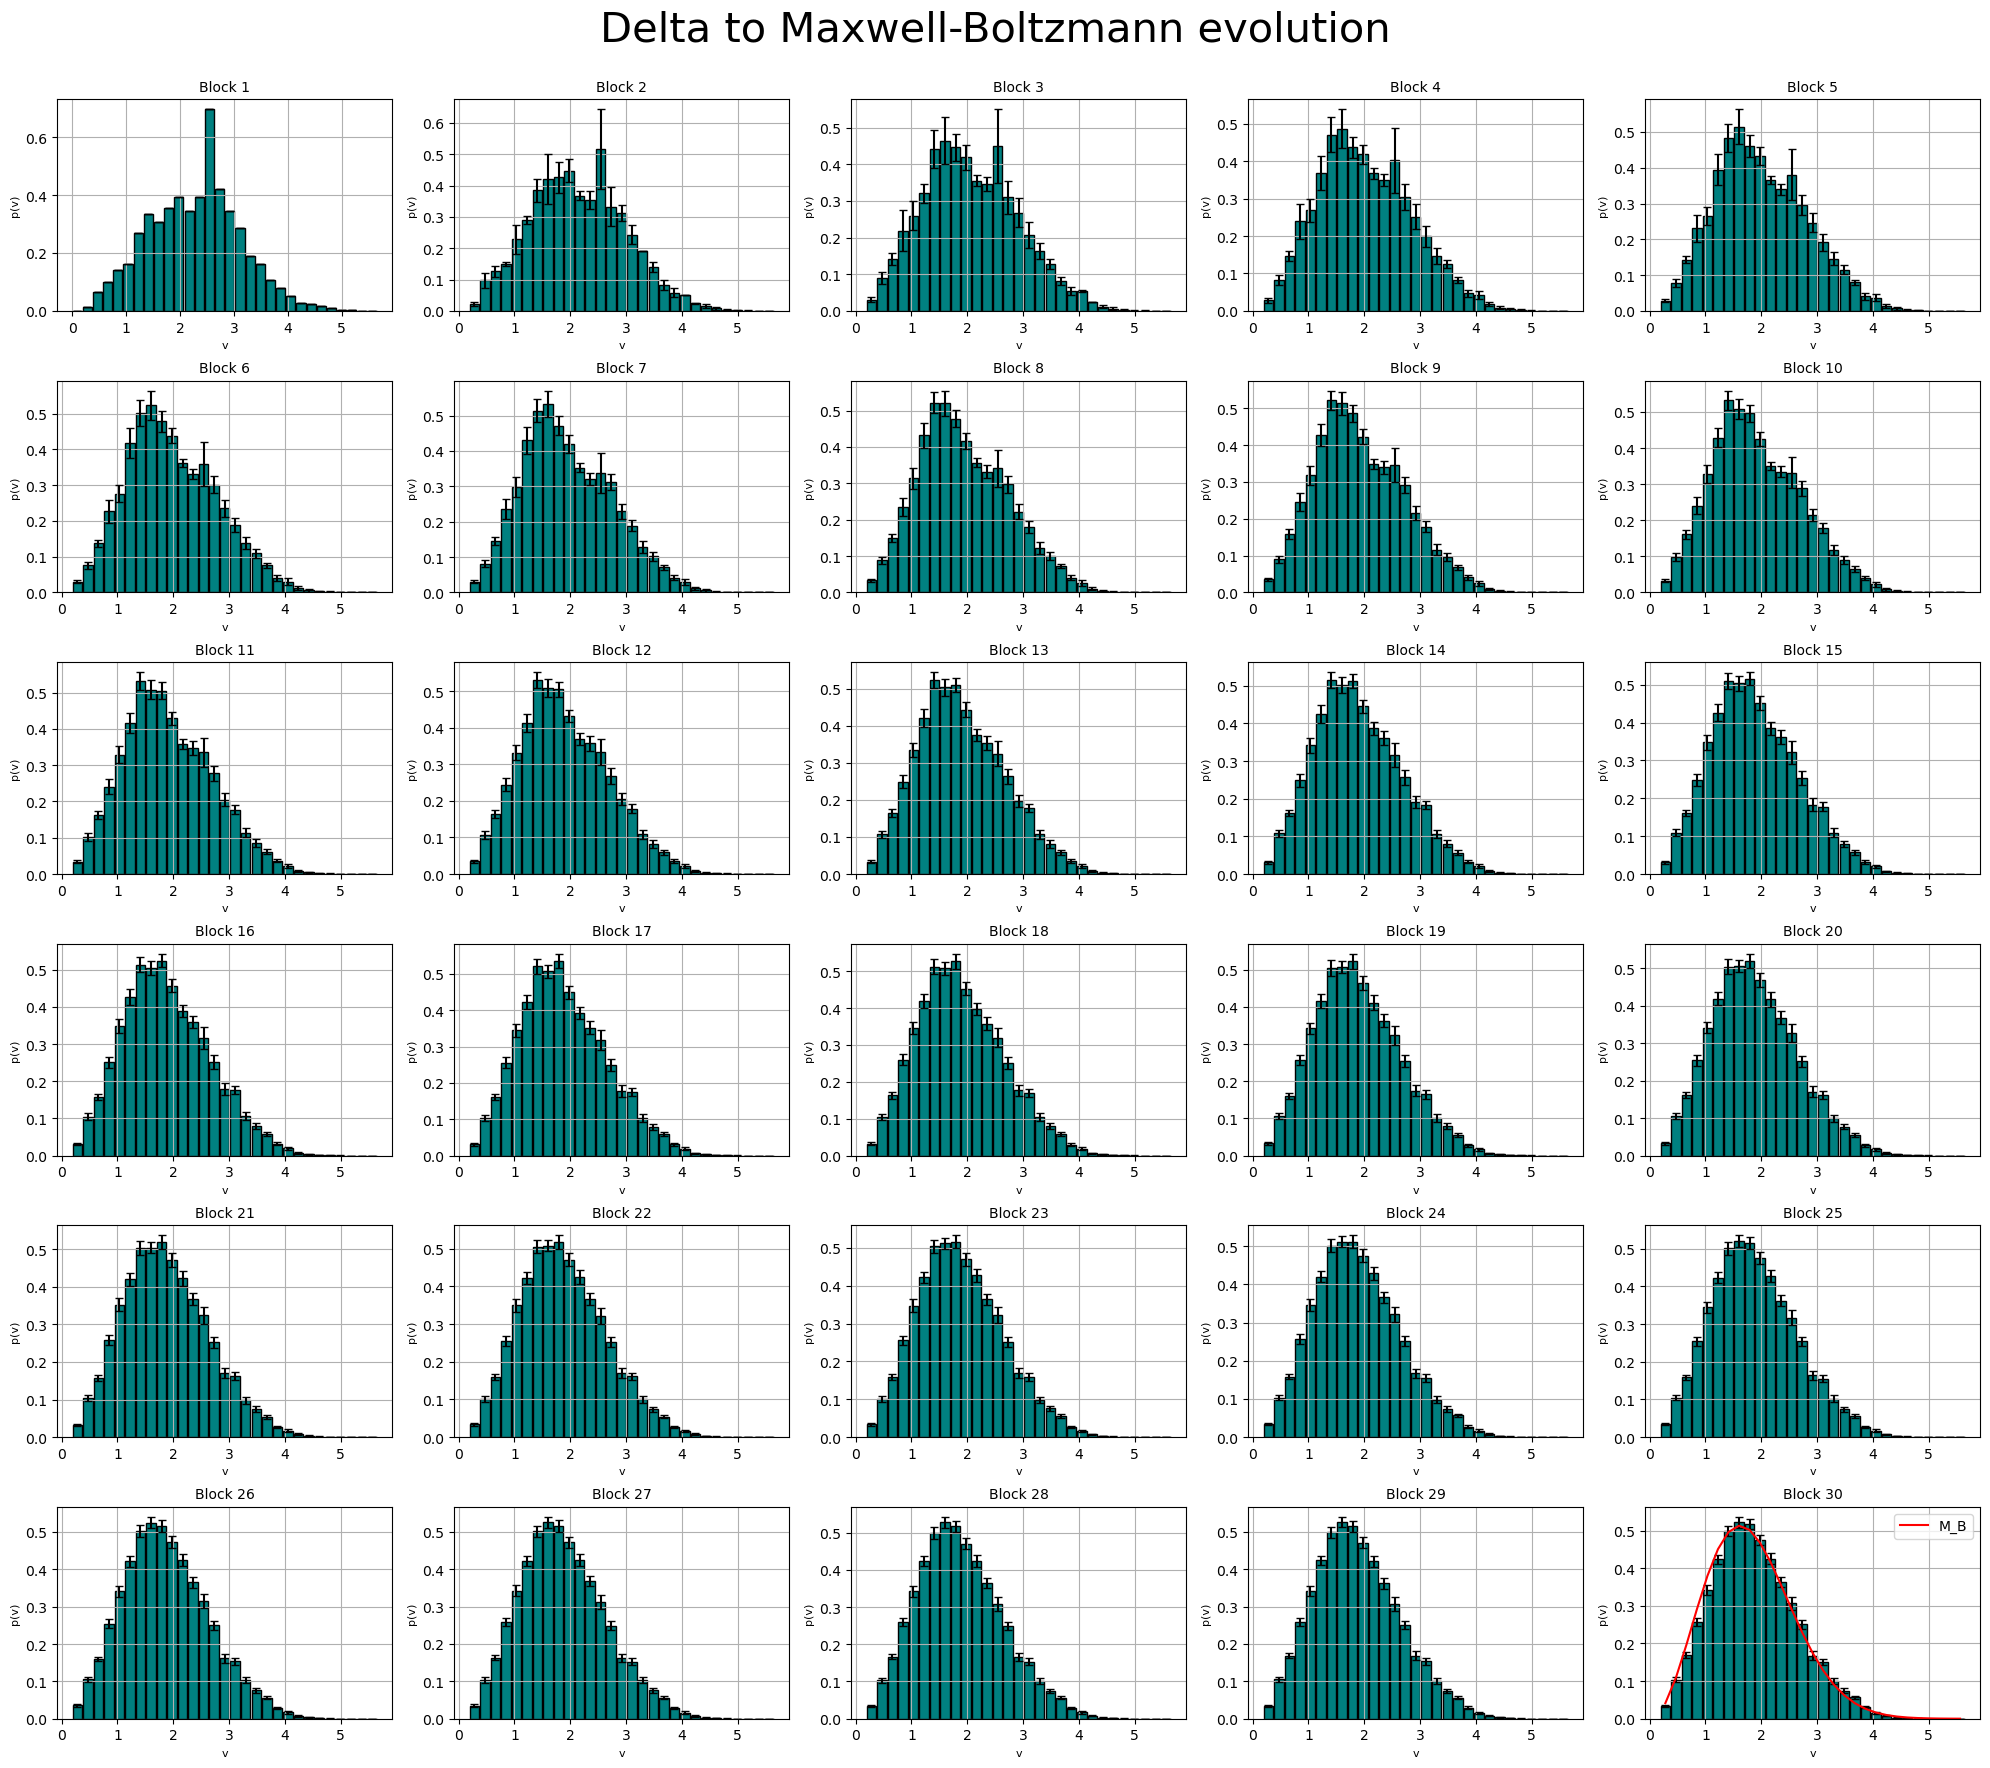

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def maxwell_boltzmann(x):
    return 1/(2*np.pi*1.31)**(3.0/2.0) * 4 * np.pi * x**2 * np.exp(-x**2 / (2 * 1.31))

with open("OUTPUT_4.2/pofv.dat") as f:
    content = f.read()

blocks = content.strip().split('\n\n')
n_blocks = len(blocks)

ncols = 5
nrows = (n_blocks + ncols - 1) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), sharex=False, sharey=False)
axs = axs.flatten()

# RIMOSSA cmap e colors

for idx, block in enumerate(blocks):
    lines = block.strip().split('\n')[1:]
    x, y, yerr = [], [], []
    for line in lines:
        parts = line.split()
        if len(parts) >= 4:
            x.append(float(parts[0]))
            y.append(float(parts[2]))
            yerr.append(float(parts[3]))
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)
    width = np.min(np.diff(x)) if len(x) > 1 else 1.0

    ax = axs[idx]
    ax.bar(x, y, width=width * 0.9, yerr=yerr, capsize=3, color='teal', edgecolor='black')  # <-- Modifica qui

    if idx == 29:
        ax.plot(x, maxwell_boltzmann(x), color='red', label='M_B')
        ax.legend()

    ax.set_title(f'Block {idx + 1}', fontsize=10)
    ax.set_xlabel('v', fontsize=8) 
    ax.set_ylabel('p(v)', fontsize=8)  
    ax.grid(True)

plt.tight_layout()
fig.suptitle('Delta to Maxwell-Boltzmann evolution', fontsize=30)
fig.subplots_adjust(top=0.93)
plt.show()


Come si osserva dai grafici prodotti l'entropia aumenta con il progredire della simulazione e la distribuzione delle velocità tende progressivamente alla M.B.
Questa simulazione mostra come, anche partendo da uno stato ordinato e non realistico, l'evoluzione dinamica porta naturalmente il sistema verso l'equilibrio termico e la distribuzione di velocità prevista dalla meccanica statistica.
Invertendo il segno del tempo il sistema simulato ripercorrerebbe a ritroso la traiettoria, ma il ritorno all’ordine iniziale non avverrebbe. Questo è legato al secondo principio della termodinamica e alla crescita dell’entropia.

### <span style="color:teal"> Esercizio 4.3 </span>

In questa simulazione ho studiato cosa accade quando si inverte il tempo in una dinamica molecolare. In particolare, ho voluto verificare se il sistema potesse tornare spontaneamente alla configurazione iniziale a bassa entropia da cui era partito nell’esercizio 4.2.


Ho avviato la simulazione partendo dalla configurazione finale dell'esercizio precedente, ma invertendo la direzione temporale (cioè scambiando l'ultima e la penultima configurazione).

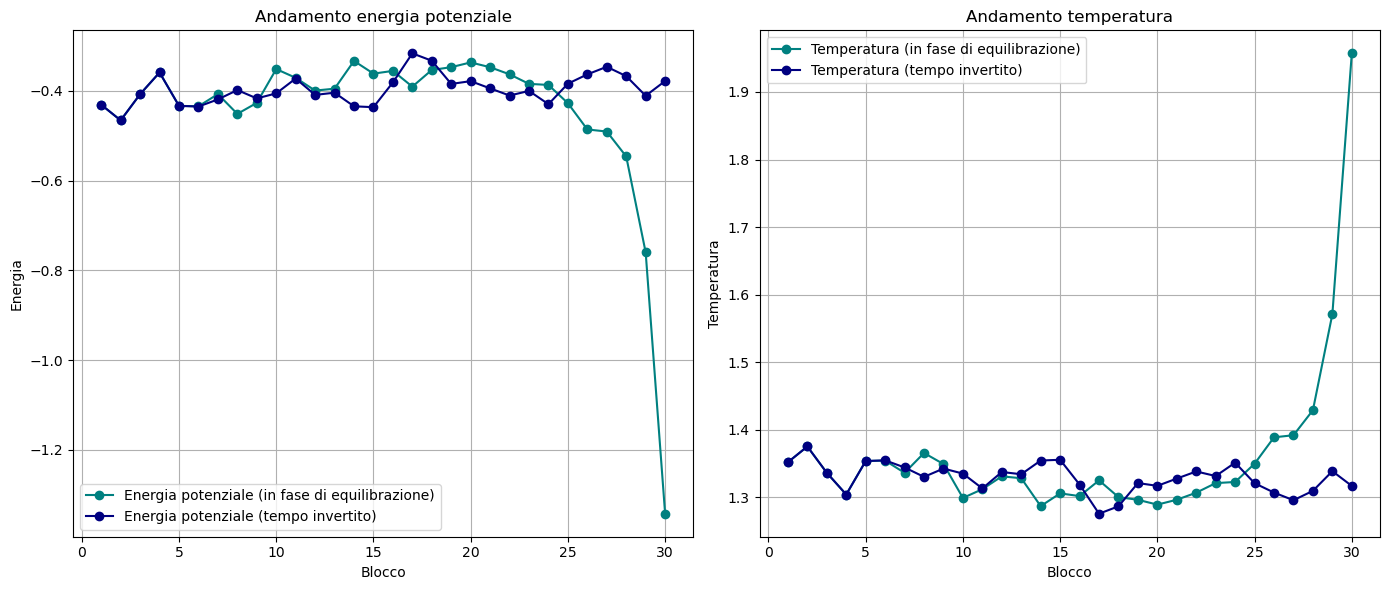

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def read_data(filename):
    with open(filename) as f:
        lines = f.read().strip().split('\n')[1:]  # Skip header
    x, y, yerr = [], [], []
    for line in lines:
        parts = line.split()
        if len(parts) >= 4:
            x.append(float(parts[0]))
            y.append(float(parts[1]))
            yerr.append(float(parts[3]))
    return np.array(x), np.array(y), np.array(yerr)

# Input files
files = [
    "OUTPUT_4.2/potential_energy.dat",
    "OUTPUT_4.3/potential_energy.dat",
    "OUTPUT_4.2/temperature.dat",
    "OUTPUT_4.3/temperature.dat"
]

labels = [
    "Energia potenziale (in fase di equilibrazione)",
    "Energia potenziale (tempo invertito)",
    "Temperatura (in fase di equilibrazione)",
    "Temperatura (tempo invertito)"
]

# Custom colors
colors = ['#008080', '#000080', '#008080', '#000080']  # Teal and Navy

# Change layout: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Plot Energia potenziale
for i in range(2):
    x, y, yerr = read_data(files[i])
    if i == 0:
        x = x[::-1]  # giro l'asse dei tempi per la simulazione del 4.2
    axs[0].errorbar(x, y, label=labels[i], fmt='-o', color=colors[i])

axs[0].set_title("Andamento energia potenziale")
axs[0].set_ylabel("Energia")
axs[0].set_xlabel("Blocco")
axs[0].legend()
axs[0].grid(True)

# Plot Temperatura
for i in range(2, 4):
    x, y, yerr = read_data(files[i])
    if i == 2:
        x = x[::-1]  # giro l'asse dei tempi per la simulazione del 4.2
    axs[1].errorbar(x, y, label=labels[i], fmt='-o', color=colors[i])

axs[1].set_title("Andamento temperatura")
axs[1].set_ylabel("Temperatura")
axs[1].set_xlabel("Blocco")
axs[1].legend()
axs[1].grid(True)

fig.tight_layout()
plt.show()


Nei grafici sopra ho invertito l'asse dei tempi della simulazione del 4.2 per poterla confrontare con la simulazione a tempo invertito.

Anche se il metodo di integrazione (Verlet) è formalmente simmetrico nel tempo, si osserva che i valori dell’energia potenziale e della temperatura coincidono solo in un primo momento, poi divergono rapidamente.
Questa divergenza è dovuta a:
  - Anche piccoli errori numerici rompono la perfetta reversibilità dinamica.
  - La configurazione iniziale era molto improbabile: solo una traiettoria precisa nello spazio delle fasi permetterebbe di raggiungerla nuovamente.

Anche se la dinamica molecolare è teoricamente reversibile, in pratica l’evoluzione inversa non porta al ritorno dello stato iniziale. Il sistema converge piuttosto verso un nuovo stato di equilibrio coerente con la distribuzione di Maxwell–Boltzmann, confermando l'aumento dell'entropia e la direzionalità del tempo.
